In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [9]:
# グレースケール化
def rgb2gray(iamg):
    gray = 0.2126*img[...,2]+0.7152*img[...,1]+0.0722*img[...,0]
    return gray

# ガウシアンフィルタ
def gaussian_filter(sigma=1.3,filter_size=3):
    # フィルタ生成
    out = np.zeros((filter_size,filter_size))
    for y in range(-(filter_size//2),filter_size//2+1):
        for x in range(-(filter_size//2),filter_size//2+1):
            out[y+(filter_size//2),x+(filter_size//2)] = np.exp(-(x**2 + y**2)/(2*(sigma**2)))
    out /= (2 * np.pi * (sigma**2))
    # 正規化
    out/=out.sum()
    return out
            
def gaussian_filtering(img,filter_size=3,sigma=1.3):
    # 1チャネルのみの画像に対応
    if img.ndim == 2:
        H,W = img.shape
        L=1
        pad_img = np.pad(img,[(filter_size//2,filter_size//2),])
    elif img.ndim == 3:
        H,W,L = img.shape
        pad_img = np.pad(img,[(filter_size//2,filter_size//2),(filter_size//2,filter_size//2),(0,0)])
        
    out = np.zeros_like(img,dtype=np.float32)
    # フィルタを生成
    K = gaussian_filter(sigma,filter_size)

    for y in range(filter_size//2,H):
        for x in range(filter_size//2,W):
            if L==1:
                out[y,x] = np.sum(K*pad_img[y-filter_size//2:y+filter_size//2+1,x-filter_size//2:x+filter_size//2+1])
            else :
                for layer in range(L):
                    out[y,x,layer] = np.sum(K*pad_img[y-filter_size//2:y+filter_size//2+1,x-filter_size//2:x+filter_size//2+1,layer])
    
    # 出力を[0,255]に収める
    out = np.clip(out, 0, 255).astype(np.uint8)
    return out

# sobelフィルタ
def sobel_filtering(img):
    Kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    H,W = img.shape
    out_x = np.zeros_like(img,dtype=np.float32)
    out_y = np.zeros_like(img,dtype=np.float32)
    # ゼロパディングした画像
    # [(y方向上部,y方向下部),(x方向上部,x方向下部),(z方向上部,z方向下部)]
    pad_img = np.pad(img,(1,1),)
    
    for y in range(1,H):
        for x in range(1,W):
            out_x[y,x] = np.sum(Kx*pad_img[y-1:y+2,x-1:x+2])
            out_y[y,x] = np.sum(Ky*pad_img[y-1:y+2,x-1:x+2])
    
    out_x = np.clip(out_x,0,255)
    out_y = np.clip(out_y,0,255)
    return out_x,out_y 

In [10]:
# canny edge detection
def cal_edge_angle(fx,fy):
    # np.power : 行列のn乗を計算
    # np.sqrt : 各要素の平方根を計算
    edge = np.sqrt(np.power(fx.astype(np.float32),2)+np.power(fy.astype(np.float32),2))
    # [0,255]の範囲に収める
    edge = np.clip(edge, 0, 255)
    # 発散しないように調整
    fx = np.maximum(fx, 1e-5)
    angle = np.arctan(fy/fx)
    return edge,angle    


def angle_quantize(angle):
    # 度数に変換
    angle = 180*angle/np.pi
    # [0,180]の範囲に収める
    angle[angle < -22.5] = 180 + angle[angle < -22.5]
    # 量子化の処理
    _angle = np.zeros_like(angle, dtype=np.uint8)
    _angle[np.where(angle <= 22.5)] = 0
    _angle[np.where((angle > 22.5) & (angle <= 67.5))] = 45
    _angle[np.where((angle > 67.5) & (angle <= 112.5))] = 90
    _angle[np.where((angle > 112.5) & (angle <= 157.5))] = 135

    return _angle

def non_maximum_suppression(edge,angle):
    H, W = angle.shape
    _edge = edge.copy()

    for y in range(H):
        for x in range(W):
            if angle[y, x] == 0:
                dx1, dy1, dx2, dy2 = -1, 0, 1, 0
            elif angle[y, x] == 45:
                dx1, dy1, dx2, dy2 = -1, 1, 1, -1
            elif angle[y, x] == 90:
                dx1, dy1, dx2, dy2 = 0, -1, 0, 1
            elif angle[y, x] == 135:
                dx1, dy1, dx2, dy2 = -1, -1, 1, 1
            if x == 0:
                dx1 = max(dx1, 0)
                dx2 = max(dx2, 0)
            if x == W-1:
                dx1 = min(dx1, 0)
                dx2 = min(dx2, 0)
            if y == 0:
                dy1 = max(dy1, 0)
                dy2 = max(dy2, 0)
            if y == H-1:
                dy1 = min(dy1, 0)
                dy2 = min(dy2, 0)
            if max(max(edge[y, x], edge[y + dy1, x + dx1]), edge[y + dy2, x + dx2]) != edge[y, x]:
                _edge[y, x] = 0

    return _edge

def hysterisis(edge,LT=30,HT=100):
    H, W = edge.shape

    # Histeresis threshold
    edge[edge >= HT] = 255
    edge[edge <= LT] = 0

    _edge = np.zeros((H + 2, W + 2), dtype=np.float32)
    _edge[1 : H + 1, 1 : W + 1] = edge

    ## 8 - Nearest neighbor
    nn = np.array(((1., 1., 1.), (1., 0., 1.), (1., 1., 1.)), dtype=np.float32)

    for y in range(1, H+2):
            for x in range(1, W+2):
                if _edge[y, x] < LT or _edge[y, x] > HT:
                    continue
                if np.max(_edge[y-1:y+2, x-1:x+2] * nn) >= HT:
                    _edge[y, x] = 255
                else:
                    _edge[y, x] = 0

    edge = _edge[1:H+1, 1:W+1]
                                
    return edge

def canny_edge_detect(img,lt,ht):
    # グレースケール化
    gray_img = rgb2gray(img)
    # ガウシアンフィルタ
    gaussian_img = gaussian_filtering(gray_img,filter_size=5,sigma=1.4)
    # sobelフィルタ
    fx,fy = sobel_filtering(gaussian_img)
    # 勾配強度 ,勾配角度を計算
    edge,angle = cal_edge_angle(fx,fy)
    # 勾配角度の量子化
    quantize_angle = angle_quantize(angle)
    # Non-maximun suppression
    nms_edge = non_maximum_suppression(edge,quantize_angle)
    # 閾値の処理
    hys_edge = hysterisis(nms_edge,lt,ht)
    return hys_edge,quantize_angle

# Hough変換を用いた直線検出

In [19]:
def hough_transform(edge):
    H,W = edge.shape
    rmax = np.sqrt(H**2 + W**2).astype(np.int32)

    hough = np.zeros((rmax*2,180),dtype=np.int32)
    ind = np.where(edge == 255) # edgeのインデックス

    # すべてのedgeについて
    for y,x in zip(ind[0],ind[1]):
        # 0から180度について
        for theta in range(0,180,1):
            t = np.pi / 180 * theta
            rho = int(x * np.cos(t) + y * np.sin(t))
            hough[rho + rmax, theta] += 1
    out = hough.astype(np.uint8)
    return out

def inverse_hough(hough,img):
    H,W,_ = img.shape
    rmax,_ = hough.shape

    out = img.copy()

    # 上位20voteを取得
    ind_x = np.argsort(hough.ravel())[::-1][:20]
    ind_y = ind_x.copy()
    thetas = ind_x % 180
    rhos = ind_y // 180 -rmax/2

    for theta, rho in zip(thetas,rhos):
        t = np.pi/180 *theta

        for x in range(W):
            if np.sin(t)!=0:
                y = - (np.cos(t) / np.sin(t)) * x + (rho) / np.sin(t)
                y = int(y)
                if y >= H or y < 0:
                    continue
                out[y, x] = [0, 0, 255]

        for y in range(H):
            if np.cos(t) != 0:
                x = - (np.sin(t) / np.cos(t)) * y + (rho) / np.cos(t)
                x = int(x)
                if x >= W or x < 0:
                    continue
                out[y, x] = [0, 0, 255]
    
    out = out.astype(np.uint8)
    return out

def voting(hough):
    rmax,_ = hough.shape

    for y in range(rmax):
        for x in range(180):
            # x,yが行列からはみ出さないように調整
            x1 = max(x-1,0)
            x2 = min(x+2,180)
            y1 = max(y-1,0)
            y2 = min(y+2,rmax-1) 
            # 注目画素と8近傍のvoteの最大値が注目画素でかつ0でないとき
            if np.max(hough[y1:y2, x1:x2]) == hough[y,x] and hough[y, x] != 0:
                pass
            else :
                hough[y,x]=0

    # 上位20voteを取得
    ind_x = np.argsort(hough.ravel())[::-1][:20]
    ind_y = ind_x.copy()
    thetas = ind_x % 180
    rhos = ind_y // 180
    _hough = np.zeros_like(hough, dtype=np.int32)
    _hough[rhos, thetas] = 255
    return _hough

def hough_line_detect(img):
    # canny edge detection
    edge,angle = canny_edge_detect(img,20,50)
    # hough変換
    hough = hough_transform(edge)
    # Non-maximun suppression
    vote = voting(hough)
    # hough変換とvotingの結果を表示
    plt.figure(facecolor="white",figsize=(6,8))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(hough.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(vote.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.show()
    # hough逆変換
    out = inverse_hough(vote,img)
    return out

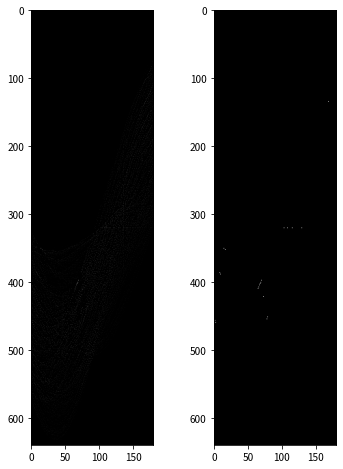

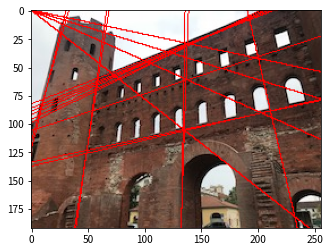

In [20]:
img = cv2.imread("./img/thorino.jpg")

out = hough_line_detect(img)

plt.figure(facecolor="white")
plt.imshow(cv2.cvtColor(out.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()